In [1]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
from scipy import stats
import calplot
import numpy as np

from bokeh.models import ColumnDataSource, FactorRange, Legend
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.plotting import output_file, save
from bokeh.models import Select
from bokeh.layouts import column
from bokeh.plotting import curdoc

# Import and overview of data

In [2]:
import os

# Set the working directory to the folder containing the file
os.chdir('/Users/kristineandersen/Desktop/Socialdata/Project/Git/kristineAA_2.github.io/Assets')
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/kristineandersen/Desktop/Socialdata/Project/Git/kristineAA_2.github.io/Assets


In [3]:
file_path = 'credit_card_transactions.csv'
df = pd.read_csv(file_path)

In [4]:
#df.head()

In [5]:
fraud_count = df['is_fraud'].sum()
print(f"Number of fraudulent transactions: {fraud_count}")

Number of fraudulent transactions: 7506


In [6]:
num_rows = len(df)
print(f"Number of rows in the dataset: {num_rows}")

Number of rows in the dataset: 1296675


In [7]:
num_cols = len(df.columns)
print(f"Number of columns in the dataset: {num_cols}")

Number of columns in the dataset: 24


In [8]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
min_date = df['trans_date_trans_time'].min()
max_date = df['trans_date_trans_time'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2019-01-01 00:00:18
Maximum date: 2020-06-21 12:13:37


In [9]:
df.columns.tolist()

['Unnamed: 0',
 'trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud',
 'merch_zipcode']


The dataset contains information about credit card transactions in the United States. It includes 1,296,675 rows and 24 columns, with each row representing a single transaction. Below is a detailed explanation of the columns:

## Columns Description:
1. **Unnamed: 0**: Index column.*
2. **trans_date_trans_time**: The timestamp of the transaction.
3. **cc_num**: Credit card number used for the transaction.*
4. **merchant**: Name of the merchant where the transaction occurred.*
5. **category**: Category of the merchant (e.g., grocery, entertainment, gas).
6. **amt**: Transaction amount in USD.
7. **first**: First name of the cardholder.*
8. **last**: Last name of the cardholder.*
9. **gender**: Gender of the cardholder.
10. **street**: Street address of the cardholder.
11. **city**: City of the cardholder.
12. **state**: State of the cardholder.
13. **zip**: ZIP code of the cardholder.
14. **lat**: Latitude of the cardholder's location.
15. **long**: Longitude of the cardholder's location.
16. **city_pop**: Population of the cardholder's city.
17. **job**: Occupation of the cardholder.
18. **dob**: Date of birth of the cardholder.
19. **trans_num**: Unique identifier for the transaction.
20. **unix_time**: Transaction time in Unix timestamp format.*
21. **merch_lat**: Latitude of the merchant's location.
22. **merch_long**: Longitude of the merchant's location.
23. **is_fraud**: Indicator of whether the transaction is fraudulent (1 for fraud, 0 otherwise).
24. **merch_zipcode**: ZIP code of the merchant's location (may contain missing values).

### Key Insights:
- The dataset spans from January 1, 2019, to June 21, 2020.
- It includes both fraudulent and non-fraudulent transactions, with 7,506 transactions marked as fraudulent.
- The data provides geographic, demographic, and transactional details, enabling analysis of fraud patterns based on location, time, and customer profiles.

### Objective:
The primary goal is to analyze the dataset to identify patterns in fraudulent transactions. This includes exploring relationships between fraud occurrences and factors such as:
- Geographic locations (e.g., states, cities, coordinates).
- Temporal patterns (e.g., time of day, day of the week, month).
- Customer profiles (e.g., age, gender, occupation).

This analysis can help in developing strategies to detect and prevent fraudulent transactions. Understanding patterns in fraudulent activities is crucial for financial institutions and businesses to enhance their fraud detection systems, minimize financial losses, and protect customers' sensitive information. By identifying key factors associated with fraud, organizations can implement targeted measures, such as real-time monitoring, improved authentication processes, and tailored risk management strategies, to mitigate risks effectively.

# Basic stats

## Cleaning the data and preprocessing

In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])


Missing values in each column:
merch_zipcode    195973
dtype: int64


In [11]:
# Check for duplicates
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


To streamline the dataset and address the issue of missing values, we removed the following columns:

1. Unnamed: 0
3. cc_num
4. merchant
7. first
8. last
20. unix_time
24. merch_zipcode

By removing these columns, we not only simplify the dataset but also resolve the issue of missing values in the `merch_zipcode` column, as it is no longer part of the dataset. This ensures a cleaner and more focused dataset for further analysis. 

In [12]:
#columns_to_remove = ['Unnamed: 0','amt','first','last','unix_time','merch_zipcode']
columns_to_remove = ['Unnamed: 0','first','last','unix_time','merch_zipcode']
df = df.drop(columns=columns_to_remove)

In [13]:
df['Date'] = pd.to_datetime(df['trans_date_trans_time'])

Lastly, we cut out the last month in 2020. As it is not a full month, it is not comparable with the other months.

In [14]:
df = df[~((df['Date'].dt.year == 2020) & (df['Date'].dt.month == 6))]

In [15]:
fraud_count = df['is_fraud'].sum()
print(f"Number of fraudulent transactions: {fraud_count}")
num_rows = len(df)
print(f"Number of rows in the dataset: {num_rows}")

Number of fraudulent transactions: 7172
Number of rows in the dataset: 1238928


Which now gives us 1,238,928 transactions where 7172 is fraudulant.

## Simple Stats

As we want to geographic, temporal and customer patterns, we will look at some basic stats for those.

In [16]:

transactions_by_state = df.groupby('state').size()
fraud_transactions_by_state = df[df['is_fraud'] == 1].groupby('state').size()

state_summary = pd.DataFrame({
    'Total Transactions': transactions_by_state,
    'Fraudulent Transactions': fraud_transactions_by_state,
}).fillna(0).astype(int)

state_summary['Fraud Percentage'] = (state_summary['Fraudulent Transactions'] / state_summary['Total Transactions']) * 100
state_summary = state_summary.sort_values(by='Fraud Percentage', ascending=False)
print(state_summary)

       Total Transactions  Fraudulent Transactions  Fraud Percentage
state                                                               
DE                      9                        9        100.000000
RI                    528                       15          2.840909
AK                   2036                       36          1.768173
NV                   5381                       47          0.873444
CO                  13217                      113          0.854960
TN                  16773                      140          0.834675
OR                  17780                      138          0.776153
NE                  23088                      175          0.757970
NH                   7882                       59          0.748541
OH                  44352                      321          0.723755
MN                  30326                      207          0.682583
FL                  40831                      278          0.680855
VA                  27949         

In [17]:
gender_counts = df['gender'].value_counts()
print(gender_counts)

gender
F    678186
M    560742
Name: count, dtype: int64


In [19]:

# Calculate age from the 'dob' column
current_year = pd.Timestamp.now().year
df['Age'] = current_year - pd.to_datetime(df['dob']).dt.year

# Create age buckets
age_bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-100']
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Count the number of occurrences in each age bucket
age_group_counts = df['Age Group'].value_counts().sort_index()

# Count the number of fraudulent transactions in each age bucket
fraud_age_group_counts = df[df['is_fraud'] == 1]['Age Group'].value_counts().sort_index()

# Combine the counts into a DataFrame
age_group_summary = pd.DataFrame({
    'Total Transactions': age_group_counts,
    'Fraudulent Transactions': fraud_age_group_counts
}).fillna(0).astype(int)

# Add a fraud percentage column
age_group_summary['Fraud Percentage'] = (age_group_summary['Fraudulent Transactions'] / age_group_summary['Total Transactions']) * 100

# Display the summary
print(age_group_summary)

           Total Transactions  Fraudulent Transactions  Fraud Percentage
Age Group                                                               
0-18                        0                        0               NaN
19-25                   18140                      118          0.650496
26-35                  178660                     1088          0.608978
36-45                  286324                     1273          0.444601
46-55                  288973                     1233          0.426683
56-65                  188480                     1403          0.744376
66-75                  135539                      907          0.669180
76-85                   74397                      517          0.694920
86-100                  67891                      622          0.916174


The gender distribution shows that females account for 678,186 transactions, while males account for 560,742. The age distribution reveals that the majority of transactions are made by individuals aged 36-45 and 46-55, with 286,324 and 288,973 transactions, respectively. The dataset includes transactions from all 50 states, with California, Texas, and New York having the highest number of transactions. Delaware has the highest fraud percentage at 100%, though it only has 9 transactions in total.

# Data Analysis

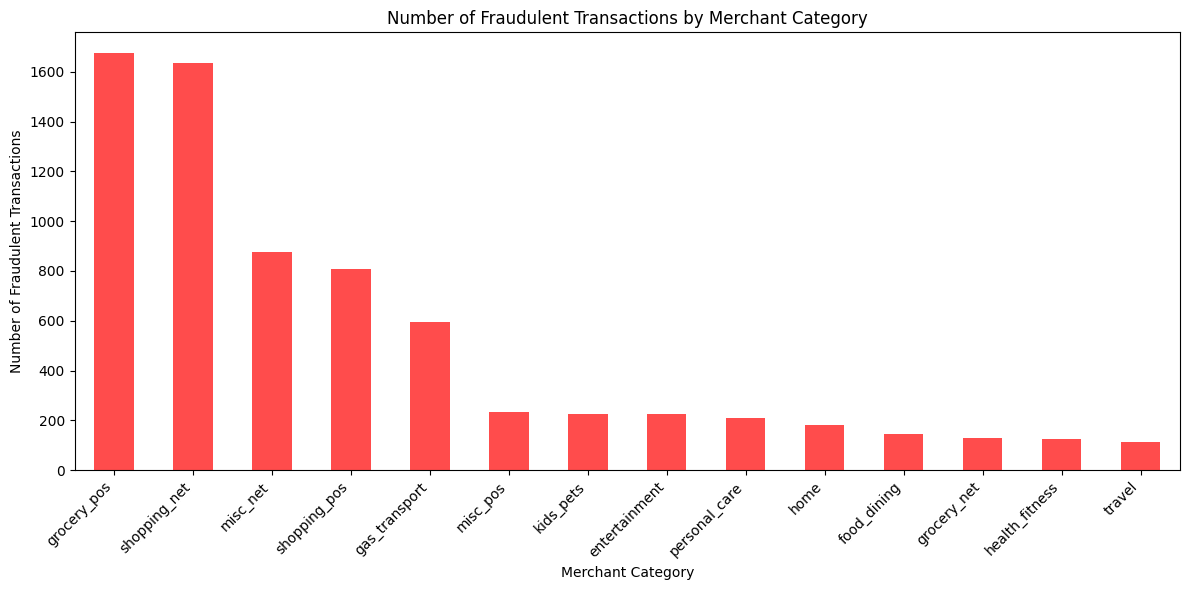

In [94]:
# Count the number of fraudulent transactions for each merchant category
fraud_by_category = df[df['is_fraud'] == 1].groupby('category').size()

# Plot the bar chart
plt.figure(figsize=(12, 6))
fraud_by_category.sort_values(ascending=False).plot(kind='bar', color='red', alpha=0.7)
plt.title('Number of Fraudulent Transactions by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("fraud_transactions_by_category.png")
plt.show()


**High Fraud in Grocery and Shopping Categories**:
    - The `grocery_pos` and `shopping_net` categories exhibit the highest number of fraudulent transactions, indicating these categories may be more susceptible to fraud.

**Moderate Fraud in Miscellaneous and Gas Categories**:
    - Categories like `misc_net`, `misc_pos`, and `gas_transport` also show a significant number of fraudulent transactions, suggesting these are common targets for fraudulent activities.

**Low Fraud in Travel and Health Categories**:
    - Categories such as `travel` and `health_fitness` have relatively fewer fraudulent transactions, which may indicate lower transaction volumes or better fraud prevention measures in these sectors.

**Insights for Fraud Prevention**:
    - The chart highlights the need for targeted fraud detection strategies in high-risk categories like grocery and shopping. Businesses in these sectors should consider implementing stricter authentication and monitoring mechanisms.


In [95]:
# Map plot
map_transactions = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Adding markers
for _, row in df[df['is_fraud'] == 1].iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        tooltip=f"Date: {row['Date']}, Category: {row['category']}, Amount: {row['amt']}, Age: {row['Age']}"
    ).add_to(map_transactions)

"""
Adding the non-fraudulent transactions to the map takes too long time to complete

for _, row in df[df['is_fraud'] == 0].iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3
    ).add_to(map_transactions)
"""
map_transactions.save("map.html")
map_transactions


The map visualization provides a geographical representation of fraudulent transactions across the United States. By plotting the locations of these transactions, it becomes evident that fraud is not uniformly distributed but rather concentrated in specific areas. States with larger populations, such as California, Texas, and New York, appear to have a higher number of fraudulent transactions, which aligns with their overall transaction volumes. However, smaller states like Delaware, despite having fewer transactions overall, exhibit a disproportionately high fraud percentage, as indicated by the dataset.

This spatial analysis highlights the importance of considering both absolute numbers and relative percentages when assessing fraud patterns. The clustering of fraudulent activities in certain regions may point to localized vulnerabilities, such as specific merchant categories or demographic factors that are more susceptible to fraud. Additionally, the map underscores the need for region-specific fraud detection and prevention strategies, as the risk factors and transaction behaviors can vary significantly across different states.

The use of red markers to denote fraudulent transactions effectively draws attention to these high-risk areas, making it easier to identify patterns and anomalies. However, the absence of non-fraudulent transaction markers, while intentional to avoid clutter, limits the ability to compare fraud against the overall transaction landscape directly on the map. Future iterations of this visualization could incorporate interactive features, such as toggling between fraudulent and non-fraudulent transactions or displaying additional details about each transaction upon hovering, to provide a more comprehensive understanding of the data.

#### calender of all transactions

In [96]:
days_difference = (df['Date'].max().date() - df['Date'].min().date()).days
daily_incidents = df.groupby(df['Date'].dt.date).size()
all_days = pd.date_range(str(df['Date'].min().date()), periods=days_difference, freq='D')
days = df['Date'].unique()
events = pd.Series(daily_incidents, index=all_days)

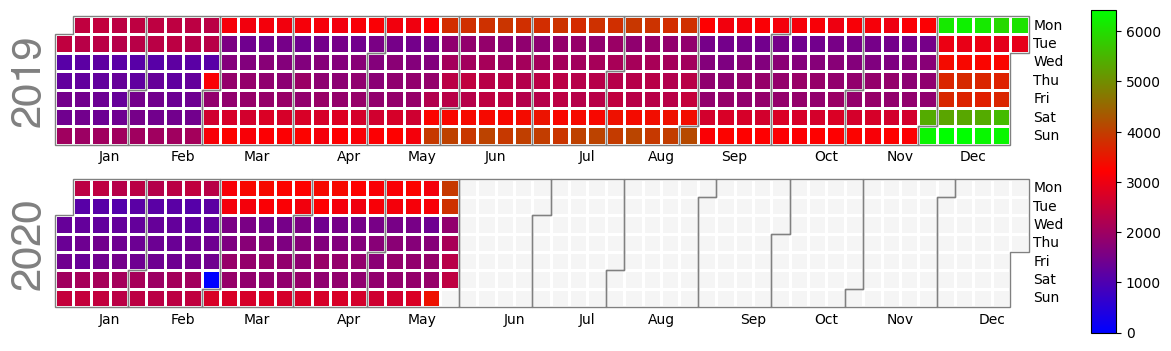

In [97]:
calplot.calplot(events, cmap='brg', colorbar=True)
plt.savefig("calendar_plot_all_transactions.png")

#### calender of fraud transactions

In [98]:
fraud_df = df[df['is_fraud'] == 1].copy()

In [99]:
days_difference = (fraud_df['Date'].max().date() - fraud_df['Date'].min().date()).days
daily_incidents = fraud_df.groupby(fraud_df['Date'].dt.date).size()
all_days = pd.date_range(str(fraud_df['Date'].min().date()), periods=days_difference, freq='D')
days = fraud_df['Date'].unique()
events = pd.Series(daily_incidents, index=all_days)

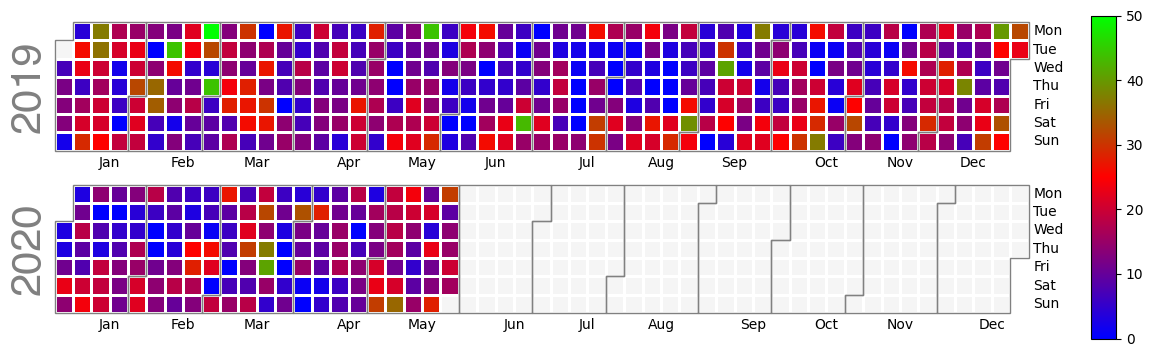

In [100]:
calplot.calplot(events, cmap='brg', colorbar=True)
plt.savefig("calendar_plot_fraun.png")

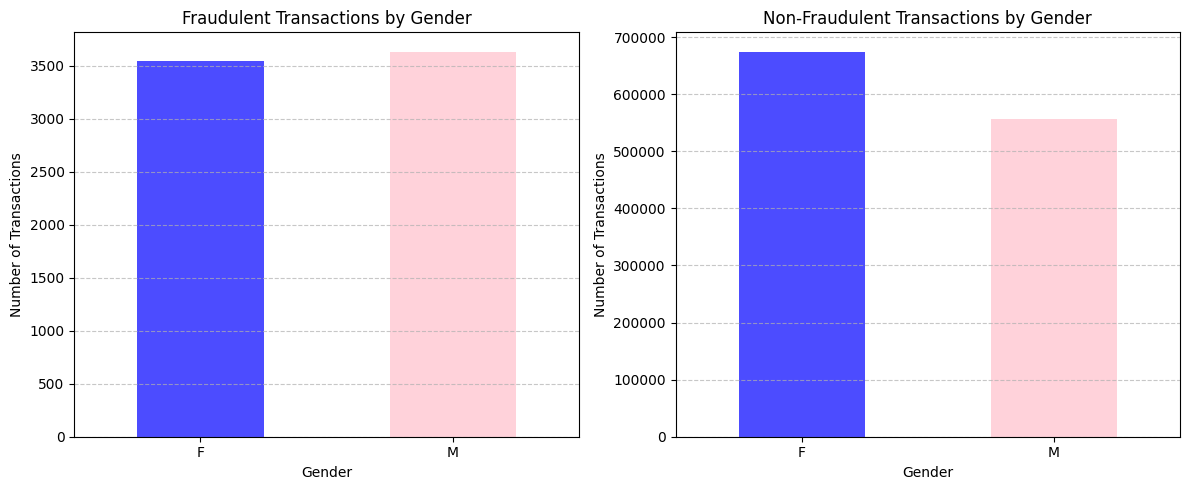

In [101]:
# Count the number of non-fraudulent transactions by gender
non_fraud_by_gender = df[df['is_fraud'] == 0].groupby('gender').size()
fraud_by_gender = df[df['is_fraud'] == 1].groupby('gender').size()
# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot fraudulent transactions
fraud_by_gender.plot(kind='bar', color=['blue', 'pink'], alpha=0.7, ax=axes[0])
axes[0].set_title('Fraudulent Transactions by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_xticks(range(len(fraud_by_gender.index)))
axes[0].set_xticklabels(fraud_by_gender.index, rotation=0)
axes[0].yaxis.grid(True, linestyle='--', alpha=0.7)  # Add horizontal gridlines

# Plot non-fraudulent transactions
non_fraud_by_gender.plot(kind='bar', color=['blue', 'pink'], alpha=0.7, ax=axes[1])
axes[1].set_title('Non-Fraudulent Transactions by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Number of Transactions')
axes[1].set_xticks(range(len(non_fraud_by_gender.index)))
axes[1].set_xticklabels(non_fraud_by_gender.index, rotation=0)
axes[1].yaxis.grid(True, linestyle='--', alpha=0.7)  # Add horizontal gridlines

plt.tight_layout()
plt.savefig("gender_dist.png")
plt.show()


The left plot highlights the number of fraudulent transactions by gender, showing a nearly equal distribution between males and females. This indicates that fraudulent activities are not significantly skewed towards one gender.

The right plot, which displays the number of non-fraudulent transactions by gender, serves as a reference to understand the overall gender distribution in the dataset. It reveals that females account for a higher proportion (just above 100,000 more) of non-fraudulent transactions compared to males. 

This suggests that while there are more females in the dataset overall, the nearly equal number of fraudulent transactions between genders indicates that, proportionally, men could be more likely to experience fraudulent transactions compared to women.


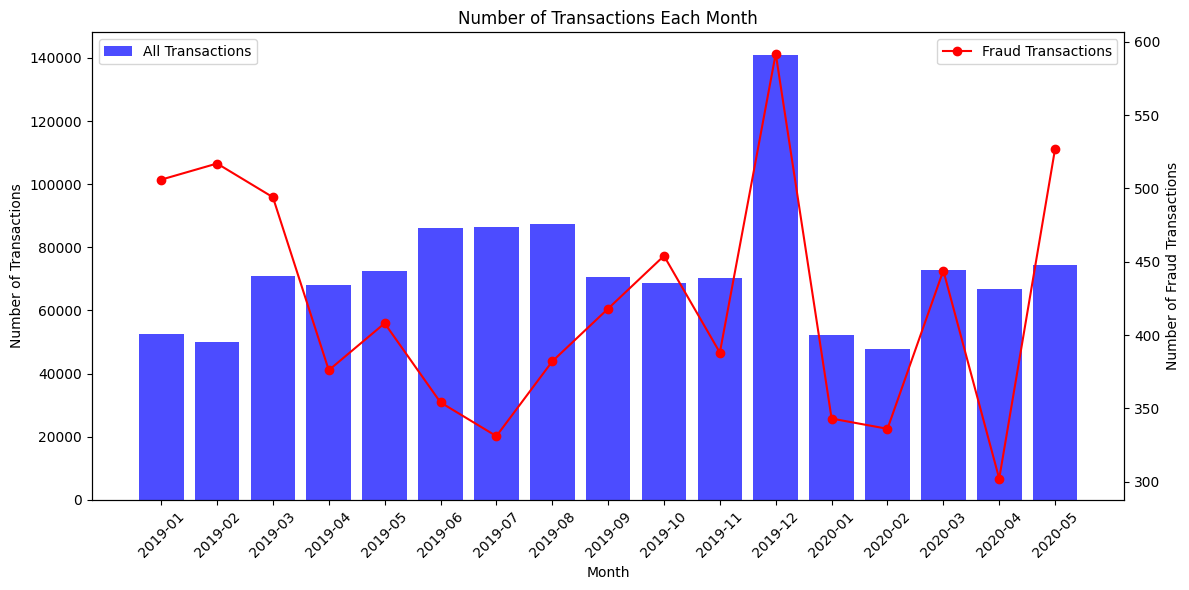

In [102]:
# Extract year and month from the transaction date
df['year_month'] = df['trans_date_trans_time'].dt.to_period('M')

# Count the number of transactions each month
monthly_transactions = df.groupby('year_month').size()

# Count the number of fraud transactions each month
monthly_fraud_transactions = df[df['is_fraud'] == 1].groupby('year_month').size()

# Plot the number of transactions each month
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for all transactions
ax1.bar(monthly_transactions.index.astype(str), monthly_transactions, color='blue', alpha=0.7, label='All Transactions')
ax1.set_title('Number of Transactions Each Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Transactions')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Line plot for fraud transactions on a secondary axis
ax2 = ax1.twinx()
ax2.plot(monthly_fraud_transactions.index.astype(str), monthly_fraud_transactions, color='red', marker='o', label='Fraud Transactions')
ax2.set_ylabel('Number of Fraud Transactions')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig("month_dist.png")
plt.show()

This plot shows monthly trends for total transactions (blue bars, left y-axis) and fraud transactions (red line, right y-axis). While total transactions fluctuate moderately, peaking sharply in December 2019, fraud transactions vary more erratically. Notably, fraud spikes in December 2019 and May 2020. No strong correlation between total and fraud transaction volume is immediately visible.

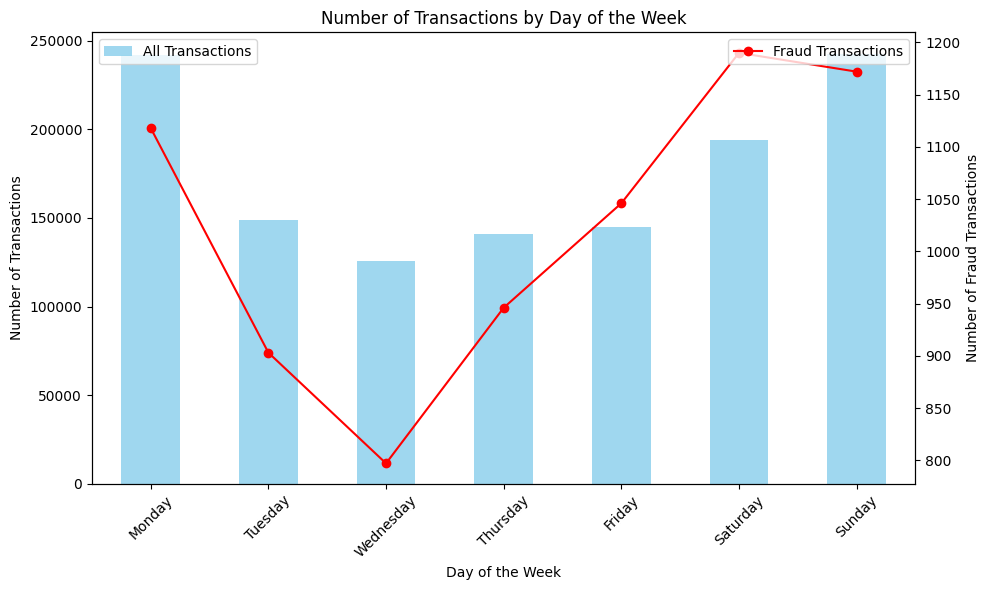

In [103]:
df['Day of Week'] = df['Date'].dt.day_name()
transactions_by_day = df['Day of Week'].value_counts()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
transactions_by_day = transactions_by_day.reindex(days_order)
fraud_transactions_by_day = df[df['is_fraud'] == 1]['Day of Week'].value_counts()

fraud_transactions_by_day = fraud_transactions_by_day.reindex(days_order)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for all transactions
transactions_by_day.plot(kind='bar', color='skyblue', alpha=0.8, ax=ax1, label='All Transactions')
ax1.set_title('Number of Transactions by Day of the Week')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Number of Transactions')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Line plot for fraud transactions on a secondary axis
ax2 = ax1.twinx()
ax2.plot(days_order, fraud_transactions_by_day, color='red', marker='o', label='Fraud Transactions')
ax2.set_ylabel('Number of Fraud Transactions')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig("transactions_by_day_with_fraud.png")
plt.show()


The plot provides a comprehensive view of the number of transactions distributed across the days of the week. It reveals that Monday, Saturday and Sunday are the most active days for transactions, with Monday slightly leading. This could indicate that people tend to make more purchases or payments at the beginning of the week, possibly due to weekend spending or planning for the week ahead. Saturday and Sunday, being a weekend day, also shows high transaction activity, which might be attributed to leisure activities, dining, or shopping. 

On the other hand, Wednesday and Thursday exhibit the lowest transaction volumes, suggesting that midweek days are relatively quieter in terms of financial activity. This trend could reflect a natural lull in consumer behavior during the middle of the week, as people may be more focused on work or other responsibilities.

Overall, the plot highlights distinct patterns in transaction behavior, with peaks at the start and end of the week and a dip during midweek. These insights could be valuable for businesses and financial institutions in planning promotions, resource allocation, or fraud detection strategies based on temporal patterns.

Lastly, we will try to look more into the categories.

In [104]:
df['Month'] = df['Date'].dt.to_period('M').astype(str)
categories = df['category'].unique().tolist()

# Create a pivot table to count transactions by "Month" and "category"
month_category_counts = df.pivot_table(index='Month', columns='category', aggfunc='size', fill_value=0)

# Reset the index to include "Month" as a column
month_category_counts = month_category_counts.reset_index()

# Convert the DataFrame to a dictionary format suitable for ColumnDataSource
source = ColumnDataSource(month_category_counts)

# Update the x_range to match the "Month" values
p = figure(
    title="Transactions by Month and Category",
    x_axis_label='Month',
    y_axis_label='Count',
    x_range=FactorRange(factors=month_category_counts['Month'].tolist()),
)

p.xaxis.major_label_orientation = 45
p.add_layout(Legend(), 'right')

# Create the stacked bar chart
p.vbar_stack(
    stackers=month_category_counts.columns[1:],  # Exclude "Month"
    x='Month',
    width=0.9,
    color=["#c9d9d3", "#718dbf", "#e84d60", "#ddb7b1", "#c9d9d3", "#718dbf", 
           "#e84d60", "#ddb7b1", "#c9d9d3", "#718dbf", "#e84d60", "#ddb7b1", 
           "#c9d9d3", "#718dbf"],
    source=source,
    legend_label=list(month_category_counts.columns[1:]),
)

# Configure legend and interactivity
p.legend.location = "top_left"
p.legend.orientation = "vertical"
p.legend.click_policy = "mute"

output_notebook()
show(p)
save(p, "transactions_by_month_and_category.html")


Loading BokehJS ...

/var/folders/76/scy6w4151918bj9rvtfnfyw00000gn/T/ipykernel_20678/3926212594.py:43: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(p, "transactions_by_month_and_category.html")
/var/folders/76/scy6w4151918bj9rvtfnfyw00000gn/T/ipykernel_20678/3926212594.py:43: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(p, "transactions_by_month_and_category.html")


'/Users/kristineandersen/Desktop/Socialdata/Project/Git/kristineAA_2.github.io/Assets/transactions_by_month_and_category.html'

In [23]:
fraud_df = df[df['is_fraud'] == 1]
fraud_df['Month'] = fraud_df['Date'].dt.to_period('M').astype(str)

/var/folders/76/scy6w4151918bj9rvtfnfyw00000gn/T/ipykernel_21968/3277677631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['Month'] = fraud_df['Date'].dt.to_period('M').astype(str)


In [24]:
categories = fraud_df['category'].unique().tolist()

# Create a pivot table to count transactions by "Month" and "category"
month_category_counts = fraud_df.pivot_table(index='Month', columns='category', aggfunc='size', fill_value=0)

# Reset the index to include "Month" as a column
month_category_counts = month_category_counts.reset_index()

# Convert the DataFrame to a dictionary format suitable for ColumnDataSource
source = ColumnDataSource(month_category_counts)

# Update the x_range to match the "Month" values
p = figure(
    title="Fraudules Transactions by Month and Category",
    x_axis_label='Month',
    y_axis_label='Count',
    x_range=FactorRange(factors=month_category_counts['Month'].tolist()),
)

p.xaxis.major_label_orientation = 45
p.add_layout(Legend(), 'right')

# Create the stacked bar chart
p.vbar_stack(
    stackers=month_category_counts.columns[1:],  # Exclude "Month"
    x='Month',
    width=0.9,
    color=["#c9d9d3", "#718dbf", "#e84d60", "#ddb7b1", "#c9d9d3", "#718dbf", 
           "#e84d60", "#ddb7b1", "#c9d9d3", "#718dbf", "#e84d60", "#ddb7b1", 
           "#c9d9d3", "#718dbf"],
    source=source,
    legend_label=list(month_category_counts.columns[1:]),
)

# Configure legend and interactivity
p.legend.location = "top_left"
p.legend.orientation = "vertical"
p.legend.click_policy = "mute"

output_notebook()
show(p)
save(p, "fraud_transactions_by_month_and_category.html")


Loading BokehJS ...

/var/folders/76/scy6w4151918bj9rvtfnfyw00000gn/T/ipykernel_21968/2438469564.py:42: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(p, "fraud_transactions_by_month_and_category.html")
/var/folders/76/scy6w4151918bj9rvtfnfyw00000gn/T/ipykernel_21968/2438469564.py:42: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(p, "fraud_transactions_by_month_and_category.html")


'/Users/kristineandersen/Desktop/Socialdata/Project/Git/kristineAA_2.github.io/Assets/fraud_transactions_by_month_and_category.html'

# Genre

We chose the genre magazine style to tell our story. And hence we used more tools from the three categories in the narrative structure, than we did from the three categories in the visual narrative.

## Visual Narrative
Since a magazine style was chosen, all design features in the transition guidance category is precluded, as well as most of the tool in the visual structuring. However from the highlighting category feature distinction as well as character direction have been used. 
The feature distinction was used in different plots, to visualize different values.

The character direction were used in creating the plots to look great, the characters were places to follow the axes, such that it looked the best.

## Narrative Structure
The ordering is linear, where the user is guided through a path, and when to look at the visualizations are given by the authors.
Since interactivity defines the different tools which can give the reader the possibility to manipulate the visualizations, the use of these are very limited due to the choice of genre. However a single tool is used in an interactive plot, where it is possible for the user to manipulate by filtering.

Finally, messaging describes how a visualization conveys insights and commentary to its audience. This is achieved in our story by including short texts fields consisting of captions and headlines. Besides this an accompanying article follows to explain the discoveries which has been made. The accompanying article consists of an introductory text, to give the reader an idea of what the data is, and what and why it will be explored.


# Visualizations

_Calendar plots_ – since we wanted to explore trends due to seasons such as the holidays, using a calendar plot made it possible for us to visualize and analyze the occurrences on specific dates throughout the year.

_Box plots_ – gave a simple clear visualization about the distribution of both the categories of different types of fraud, as well as making a great simple visualization about the gender distribution.

_Map_ – we wanted to explore if it was possible to examine trends based on geographical places

_The interactive plot_ - provided valuable insight into which fraud categories are most prevalent while displaying their monthly distributions. This dynamic visualization enabled us to explore potential seasonal trends and better understand how fraud patterns vary throughout the year.


# Discussion

Overall, the visualizations effectively illustrated periods of high transaction volumes alongside comparisons to fraudulent transactions. Additionally, the use of two box plots to depict the gender distribution among fraud victims successfully highlighted potential risk factors.

One area for improvement would be incorporating a choropleth map that color-codes each state based on the percentage of fraudulent transactions. Since our analysis references state-specific fraud rates, such a map would enhance our spatial understanding and strengthen the narrative.

Furthermore, the dataset’s limited scope prevented us from drawing clear conclusions on certain aspects of our investigation. Access to a larger dataset spanning multiple years would enable a more comprehensive exploration of trends, thereby providing a more complete picture of the fraud landscape.



| Section           | Person in charge | 
|-------------------|------------------|
| Motivation        | Kristine         | 
| Basic stats       | Kristine         | 
| Data analysis     | Krisitne         | 
| Genre             | Karoline         | 
| Visualizations    | Karoline         | 
| Discussion        | Karoline         | 
| Git setup         | Kristine         | 
| Story line        | Karoline         | 

